<a href="https://colab.research.google.com/github/PersGraphics/CNN/blob/main/4_2_Ejercicio3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Notebook: Image Recognition - Gender Detection

This Notebook is part of my Capstone Project for the Machine Learning Engineer Nanodegree of Udacity. I have modifed the code regarding the one I submitted in Udacity due some limitation on Kaggle´s Notebook:

* This dataset on Kaggle do not allow to work with the "flow_from_directory" method of keras, as the images need to be on different folders depending the target and type of data (train, validation, test). For this I am working with the "flow" method.
* Memory limitation, so I am using a reduced amount of images to train and validate.

### Now let´s start

Image recognition is one of the many applications of Machine Learning, it can solve problems for security purposes, object detection, face detection, healthcare, entertainment, among others. This application has an enormous potential to help our society, so it is important to find new uses for this tool, improve the current methods and get more accurate and useful insights from it. A good example of these applications, is the work done by research of The Chinese University of Hong Kong for face detection using deep learning (https://arxiv.org/abs/1509.06451).

In this project, we will build a Machine Learning Algorithm using CNN to predict from a giving picture if the celebrity is male or female.


---

## Dataset

For this project we will use the CelebA dataset (http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html), which is available on Kaggle.

Description of the CelebA dataset from kaggle (https://www.kaggle.com/jessicali9530/celeba-dataset): 

### Context

A popular component of computer vision and deep learning revolves around identifying faces for various applications from logging into your phone with your face or searching through surveillance images for a particular suspect. This dataset is great for training and testing models for face detection, particularly for recognising facial attributes such as finding people with brown hair, are smiling, or wearing glasses. Images cover large pose variations, background clutter, diverse people, supported by a large quantity of images and rich annotations. This data was originally collected by researchers at MMLAB, The Chinese University of Hong Kong (specific reference in Acknowledgment section).

### Content

#### Overall

202,599 number of face images of various celebrities
10,177 unique identities, but names of identities are not given
40 binary attribute annotations per image
5 landmark locations

#### Data Files

- <b>img_align_celeba.zip</b>: All the face images, cropped and aligned
- <b>list_eval_partition.csv</b>: Recommended partitioning of images into training, validation, testing sets. Images 1-162770 are training, 162771-182637 are validation, 182638-202599 are testing
- <b>list_bbox_celeba.csv</b>: Bounding box information for each image. "x_1" and "y_1" represent the upper left point coordinate of bounding box. "width" and "height" represent the width and height of bounding box
- <b>list_landmarks_align_celeba.csv</b>: Image landmarks and their respective coordinates. There are 5 landmarks: left eye, right eye, nose, left mouth, right mouth
- <b>list_attr_celeba.csv</b>: Attribute labels for each image. There are 40 attributes. "1" represents positive while "-1" represents negative

---


### Import libraries

In [ ]:
import pandas as pd
import numpy as np
import cv2    
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import f1_score

from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential, Model 
from tensorflow.keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import SGD

from IPython.core.display import display, HTML
from PIL import Image
from io import BytesIO
import base64

plt.style.use('ggplot')

%matplotlib inline

In [ ]:
import tensorflow as tf
print(tf.__version__)

2.12.0


## Step 1: Data Exploration

We will be using the CelebA Dataset, which includes images of 178 x 218 px. Below is an example of how the pictures looks like.

In [ ]:
!unzip -n '/content/drive/MyDrive/archive (6)' >> /dev/null

In [ ]:
# set variables 
images_folder = 'img_align_celeba/img_align_celeba/'

EXAMPLE_PIC = images_folder + '000506.jpg'

TRAINING_SAMPLES = 8500 # mas o menos lo máximo que permite
VALIDATION_SAMPLES = 2000
TEST_SAMPLES = 2000
IMG_WIDTH = 178
IMG_HEIGHT = 218
BATCH_SIZE = 16
NUM_EPOCHS = 10

### Load the attributes of every picture
File: list_attr_celeba.csv

In [ ]:
# import the data set that include the attribute for each picture
df_attr = pd.read_csv('list_attr_celeba.csv')
df_attr.set_index('image_id', inplace=True)
df_attr.replace(to_replace=-1, value=0, inplace=True) #replace -1 by 0
df_attr.shape

(202599, 40)

### List of the available attribute in the CelebA dataset

40 Attributes

In [ ]:
# List of available attributes
for i, j in enumerate(df_attr.columns):
    print(i, j)

0 5_o_Clock_Shadow
1 Arched_Eyebrows
2 Attractive
3 Bags_Under_Eyes
4 Bald
5 Bangs
6 Big_Lips
7 Big_Nose
8 Black_Hair
9 Blond_Hair
10 Blurry
11 Brown_Hair
12 Bushy_Eyebrows
13 Chubby
14 Double_Chin
15 Eyeglasses
16 Goatee
17 Gray_Hair
18 Heavy_Makeup
19 High_Cheekbones
20 Male
21 Mouth_Slightly_Open
22 Mustache
23 Narrow_Eyes
24 No_Beard
25 Oval_Face
26 Pale_Skin
27 Pointy_Nose
28 Receding_Hairline
29 Rosy_Cheeks
30 Sideburns
31 Smiling
32 Straight_Hair
33 Wavy_Hair
34 Wearing_Earrings
35 Wearing_Hat
36 Wearing_Lipstick
37 Wearing_Necklace
38 Wearing_Necktie
39 Young


### Example of a picture in CelebA dataset
178 x 218 px

Smiling    1
Male       0
Young      1
Name: 000506.jpg, dtype: int64

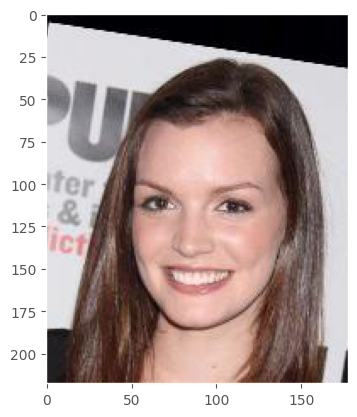

In [ ]:
# plot picture and attributes
img = load_img(EXAMPLE_PIC)
plt.grid(False)
plt.imshow(img)
df_attr.loc[EXAMPLE_PIC.split('/')[-1]][['Smiling','Male','Young']] #some attributes

### Distribution of the Attribute

As specified before, this Notebook is an imagine recognition project of the Gender. There are more Female gender than Male gender in the data set. This give us some insight about the need to balance the data in next steps.

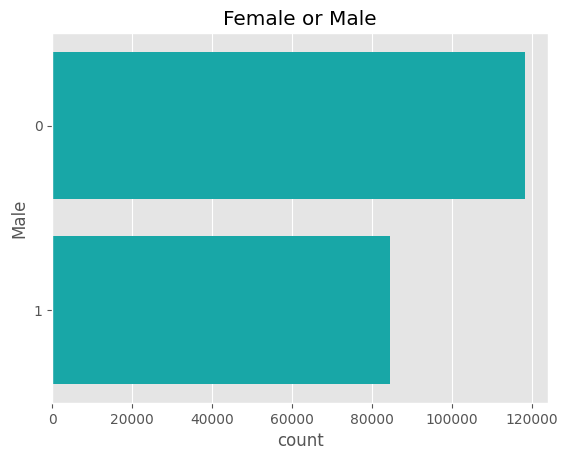

In [ ]:
# Female or Male?
plt.title('Female or Male')
sns.countplot(y='Male', data=df_attr, color="c")
plt.show()

## Step 2: Split Dataset into Training, Validation and Test

The recommended partitioning of images into training, validation, testing of the data set is: 
* 1-162770 are training
* 162771-182637 are validation
* 182638-202599 are testing

The partition is in file <b>list_eval_partition.csv</b>

Due time execution, by now we will be using a reduced number of images:

* Training 20000 images
* Validation 5000 images
* Test 5000 Images


In [ ]:
# Recomended partition
df_partition = pd.read_csv('list_eval_partition.csv')
df_partition.head()

,image_id,partition
0,000001.jpg,0
1,000002.jpg,0
2,000003.jpg,0
3,000004.jpg,0
4,000005.jpg,0


In [ ]:
# display counter by partition
# 0 -> TRAINING
# 1 -> VALIDATION
# 2 -> TEST
df_partition['partition'].value_counts().sort_index()

0    162770
1     19867
2     19962
Name: partition, dtype: int64

#### Join the partition and the attributes in the same data frame

In [ ]:
# join the partition with the attributes
df_partition.set_index('image_id', inplace=True)
df_par_attr = df_partition.join(df_attr['Male'], how='inner')
df_par_attr.head()

,partition,Male
image_id,,
000001.jpg,0,0
000002.jpg,0,0
000003.jpg,0,1
000004.jpg,0,0
000005.jpg,0,0


### 2.1: Generate Partitions (Train, Validation, Test)

Number of images need to be balanced in order to get a good performance for the model, each model will have its own folder of training, validation and test balanced data.

This degree project explains how imbalanced training data impact on CNNs models:

https://www.kth.se/social/files/588617ebf2765401cfcc478c/PHensmanDMasko_dkand15.pdf

On this step we will create functions that will help us to create each partition.

In [ ]:
def load_reshape_img(fname):
    img = load_img(fname)
    x = img_to_array(img)/255.
    x = x.reshape((1,) + x.shape)

    return x


def generate_df(partition, attr, num_samples):
    '''
    partition
        0 -> train
        1 -> validation
        2 -> test
    
    '''
    
    df_ = df_par_attr[(df_par_attr['partition'] == partition) 
                           & (df_par_attr[attr] == 0)].sample(int(num_samples/2))
    df_ = pd.concat([df_,
                      df_par_attr[(df_par_attr['partition'] == partition) 
                                  & (df_par_attr[attr] == 1)].sample(int(num_samples/2))])

    # for Train and Validation
    if partition != 2:
        x_ = np.array([load_reshape_img(images_folder + fname) for fname in df_.index])
        x_ = x_.reshape(x_.shape[0], 218, 178, 3)
        y_ = to_categorical(df_[attr],2)
    # for Test
    else:
        x_ = []
        y_ = []

        for index, target in df_.iterrows():
            im = cv2.imread(images_folder + index)
            im = cv2.resize(cv2.cvtColor(im, cv2.COLOR_BGR2RGB), (IMG_WIDTH, IMG_HEIGHT)).astype(np.float32) / 255.0
            im = np.expand_dims(im, axis =0)
            x_.append(im)
            y_.append(target[attr])

    return x_, y_

## Step 3: Pre-processing Images: Data Augmentation

Generates Data Augmentation for iamges.

Data Augmentation allows to generate images with modifications to the original ones. The model will learn from these variations (changing angle, size and position), being able to predict better never seen images that could have the same variations in position, size and position.

### 3.1. Let's start with an example: Data Augmentation

This is how an image will look like after data augmentation (based in the giving parameters below).

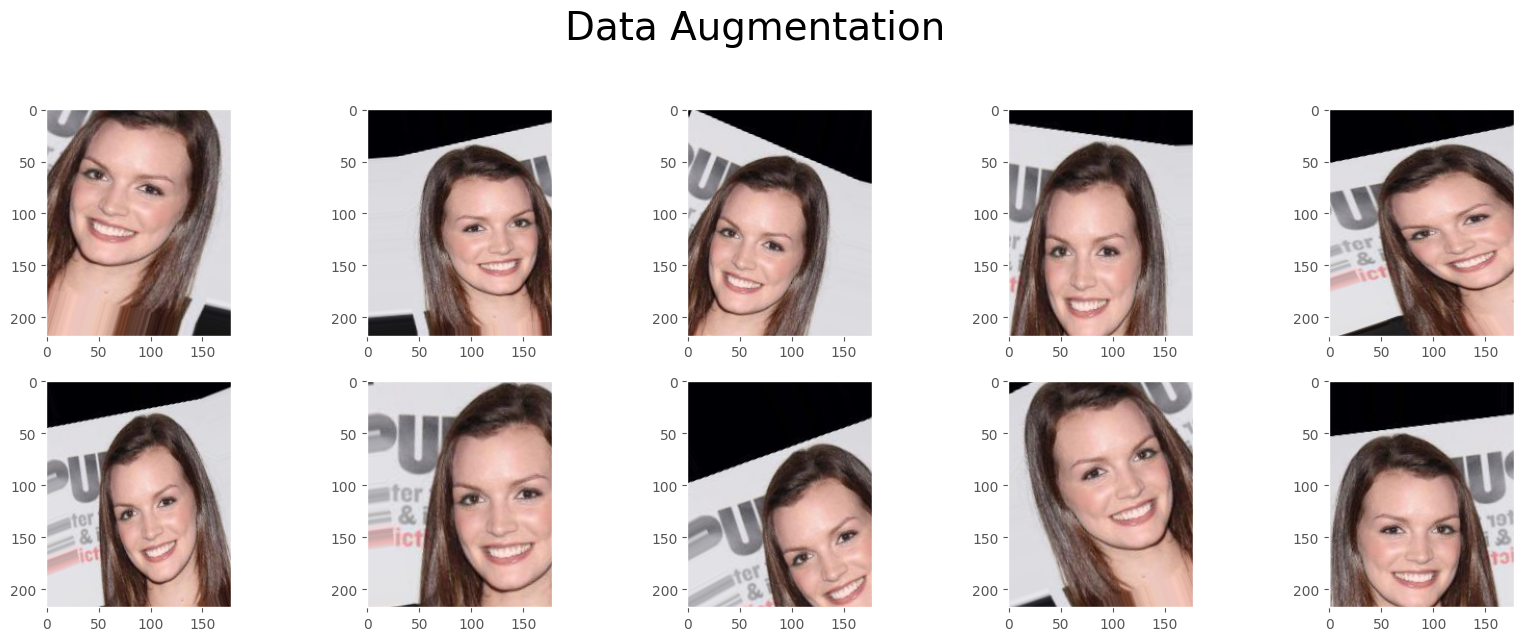

In [ ]:
# Generate image generator for data augmentation
datagen =  ImageDataGenerator(
  #preprocessing_function=preprocess_input,
  rotation_range=30,
  width_shift_range=0.2,
  height_shift_range=0.2,
  shear_range=0.2,
  zoom_range=0.2,
  horizontal_flip=True
)

# load one image and reshape
img = load_img(EXAMPLE_PIC)
x = img_to_array(img)/255.
x = x.reshape((1,) + x.shape)

# plot 10 augmented images of the loaded iamge
plt.figure(figsize=(20,10))
plt.suptitle('Data Augmentation', fontsize=28)

i = 0
for batch in datagen.flow(x, batch_size=1):
    plt.subplot(3, 5, i+1)
    plt.grid(False)
    plt.imshow( batch.reshape(218, 178, 3))
    
    if i == 9:
        break
    i += 1
    
plt.show()

The result is a new set of images with modifications from the original one, that allows to the model to learn from these variations in order to take this kind of images during the learning process and predict better never seen images.

### 3.2. Build Data Generators

In [ ]:
# Train data
x_train, y_train = generate_df(0, 'Male', TRAINING_SAMPLES)

# Train - Data Preparation - Data Augmentation with generators
train_datagen =  ImageDataGenerator(
  preprocessing_function=preprocess_input,
  rotation_range=30,
  width_shift_range=0.2,
  height_shift_range=0.2,
  shear_range=0.2,
  zoom_range=0.2,
  horizontal_flip=True,
)

train_datagen.fit(x_train)

train_generator = train_datagen.flow(
x_train, y_train,
batch_size=BATCH_SIZE,
)

In [ ]:
# Validation Data
x_valid, y_valid = generate_df(1, 'Male', VALIDATION_SAMPLES)

'''
# Validation - Data Preparation - Data Augmentation with generators
valid_datagen = ImageDataGenerator(
  preprocessing_function=preprocess_input,
)

valid_datagen.fit(x_valid)

validation_generator = valid_datagen.flow(
x_valid, y_valid,
)
'''

'\n# Validation - Data Preparation - Data Augmentation with generators\nvalid_datagen = ImageDataGenerator(\n  preprocessing_function=preprocess_input,\n)\n\nvalid_datagen.fit(x_valid)\n\nvalidation_generator = valid_datagen.flow(\nx_valid, y_valid,\n)\n'

With the data generator created and data for validation, we are ready to start modeling.

## Step 4: Build the Model - Gender Recognition

### 4.1. Set the Model

In [ ]:
# Import InceptionV3 Model
inc_model = InceptionV3(weights='imagenet', # cambiado
                        include_top=False,
                        input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))

print("number of layers:", len(inc_model.layers))
#inc_model.summary()

87910968/87910968 [==============================] - 6s 0us/step
number of layers: 311


<h2>Inception-V3 model structure</h2>
This is the structure of the Inception-V3 model, developed over the imagenet dataset.


<img src="https://i.imgur.com/kdXUzu1.png" width="1000px"/>
source: https://hackathonprojects.files.wordpress.com/2016/09/74911-image03.png

The top layers (including classification) are not included. These layers will be replaced for the following layers:

In [ ]:
#Adding custom Layers
x = inc_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation="relu")(x)
x = Dropout(0.5)(x)
x = Dense(512, activation="relu")(x)
predictions = Dense(2, activation="softmax")(x)

<h2>New Top layers</h2>
Layers to be trained with the new model.
<img src="https://i.imgur.com/rWF7bRY.png" width="800px"/>

In [ ]:
# creating the final model 
model_ = Model(inputs=inc_model.input, outputs=predictions)

# Lock initial layers to do not be trained
for layer in model_.layers[:52]:
    layer.trainable = False

# compile the model
model_.compile(optimizer=SGD(lr=0.0001, momentum=0.9)
                    , loss='categorical_crossentropy'
                    , metrics=['accuracy'])

### 4.2. Train Model

In [ ]:
#https://keras.io/models/sequential/ fit generator
checkpointer = ModelCheckpoint(filepath='weights.best.inc.male.hdf5', 
                               verbose=1, save_best_only=True)

In [ ]:
hist = model_.fit_generator(train_generator
                     , validation_data = (x_valid, y_valid)
                      , steps_per_epoch= TRAINING_SAMPLES/BATCH_SIZE
                      , epochs= NUM_EPOCHS
                      , callbacks=[checkpointer]
                      , verbose=1
                      , workers=8
                      , use_multiprocessing = True # Para que vaya mas rapido
                    )

<ipython-input-29-c00a1404a2b3>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  hist = model_.fit_generator(train_generator


Epoch 1/10
532/531 [==============================] - ETA: 0s - loss: 0.4499 - accuracy: 0.7896
Epoch 1: val_loss improved from inf to 0.66933, saving model to weights.best.inc.male.hdf5
531/531 [==============================] - 152s 221ms/step - loss: 0.4499 - accuracy: 0.7896 - val_loss: 0.6693 - val_accuracy: 0.5740
Epoch 2/10
532/531 [==============================] - ETA: 0s - loss: 0.2782 - accuracy: 0.8867
Epoch 2: val_loss improved from 0.66933 to 0.42074, saving model to weights.best.inc.male.hdf5
531/531 [==============================] - 119s 219ms/step - loss: 0.2782 - accuracy: 0.8867 - val_loss: 0.4207 - val_accuracy: 0.8135
Epoch 3/10
532/531 [==============================] - ETA: 0s - loss: 0.2326 - accuracy: 0.9056
Epoch 3: val_loss did not improve from 0.42074
531/531 [==============================] - 124s 229ms/step - loss: 0.2326 - accuracy: 0.9056 - val_loss: 0.4299 - val_accuracy: 0.8395
Epoch 4/10
532/531 [==============================] - ETA: 0s - loss: 0.19

#### The best model after NUM_epech got an accuracy over the validation data of 95.75%.

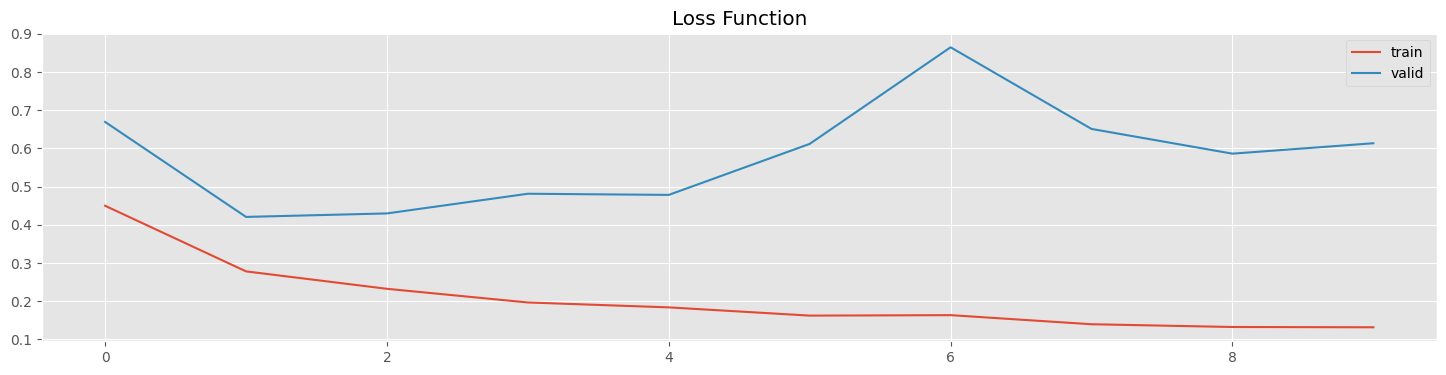

In [ ]:
# Plot loss function value through epochs
plt.figure(figsize=(18, 4))
plt.plot(hist.history['loss'], label = 'train')
plt.plot(hist.history['val_loss'], label = 'valid')
plt.legend()
plt.title('Loss Function')
plt.show()

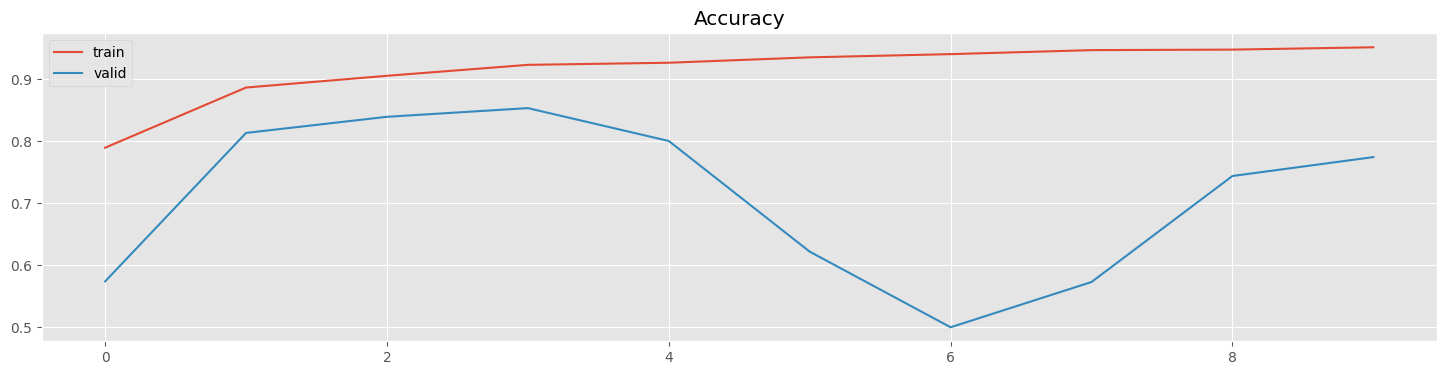

In [ ]:
# Plot accuracy through epochs
plt.figure(figsize=(18, 4))
plt.plot(hist.history['accuracy'], label = 'train')
plt.plot(hist.history['val_accuracy'], label = 'valid')
plt.legend()
plt.title('Accuracy')
plt.show()

### 4.3. Model Evaluation

In [ ]:
#load the best model
model_.load_weights('weights.best.inc.male.hdf5')

In [ ]:
# Test Data
x_test, y_test = generate_df(2, 'Male', TEST_SAMPLES)

# generate prediction
model_predictions = [np.argmax(model_.predict(feature)) for feature in x_test ]

# report test accuracy
test_accuracy = 100 * np.sum(np.array(model_predictions)==y_test) / len(model_predictions)
print('Model Evaluation')
print('Test accuracy: %.4f%%' % test_accuracy)
print('f1_score:', f1_score(y_test, model_predictions))

1/1 [==============================] - 0s 30ms/step
Model Evaluation
Test accuracy: 81.1000%
f1_score: 0.8267644362969752


### 5. Conclusion

The built model using transfer learning from the InceptionV3 and adding custom layers successfully recognize the gender giving certain picture with <b>94.8% of accuracy over the test data</b>. Nevertheless, there are some limitations detected and opportunities for improvements:

* Train the algorithms with the entire data set of images. Due computational resource limitation, the model was train with a subset of images. Having an appropriate machine, the model can be trained including all the images. This will make the algorithm to learn from different context of the picture giving it more experience in order to predict better never seen images.

* Use difference structures for the CNNs. This approach could give better performance to the model, is an expensive task anyway, as the model can be measure on the test data set after is trained, and this takes time and computational resources.

* Watching the pictures of the CelebA Data Set, most of the pictures are almost a close-up to the face of the subject, this leads to the model to learn from this type of pictures, and in situation where the subjects is just a small portion of a picture, the model could not perform well. To deal with this, more sophisticated preprocessing data can be added or complement the data set with pictures that are not entirely based in close-up to the face of the subject.

* Environments where there are more than one subject in the picture was not part of the scope of this Notebook, but it is a good improvement in order to develop a better application. OpenCV is a good candidate to help with this development, as it very accurate to detect feces and its position in the pictures, then that portion of the picture (the faces) can be classified separately using the developed models on this project. 



### 6. Let's play with the Model

In [ ]:
#dictionary to name the prediction
gender_target = {0: 'Female'
                , 1: 'Male'}

def img_to_display(filename):
    # inspired on this kernel:
    # https://www.kaggle.com/stassl/displaying-inline-images-in-pandas-dataframe
    # credits to stassl :)
    
    i = Image.open(filename)
    i.thumbnail((200, 200), Image.LANCZOS)
    
    with BytesIO() as buffer:
        i.save(buffer, 'jpeg')
        return base64.b64encode(buffer.getvalue()).decode()
    

def display_result(filename, prediction, target):
    '''
    Display the results in HTML
    
    '''

    gender = 'Male'
    gender_icon = "https://i.imgur.com/nxWan2u.png"
        
    if prediction[1] <= 0.5:
        gender_icon = "https://i.imgur.com/oAAb8rd.png"
        gender = 'Female'
            
    display_html = '''
    <div style="overflow: auto;  border: 2px solid #D8D8D8;
        padding: 5px; width: 420px;" >
        <img src="data:image/jpeg;base64,{}" style="float: left;" width="200" height="200">
        <div style="padding: 10px 0px 0px 20px; overflow: auto;">
            <img src="{}" style="float: left;" width="40" height="40">
            <h3 style="margin-left: 50px; margin-top: 2px;">{}</h3>
            <p style="margin-left: 50px; margin-top: -6px; font-size: 12px">{} prob.</p>
            <p style="margin-left: 50px; margin-top: -16px; font-size: 12px">Real Target: {}</p>
            <p style="margin-left: 50px; margin-top: -16px; font-size: 12px">Filename: {}</p>
        </div>
    </div>
    '''.format(img_to_display(filename)
               , gender_icon
               , gender
               , "{0:.2f}%".format(round(max(prediction)*100,2))
               , gender_target[target]
               , filename.split('/')[-1]
               )

    display(HTML(display_html))

In [ ]:
def gender_prediction(filename):
    '''
    predict the gender
    
    input:
        filename: str of the file name
        
    return:
        array of the prob of the targets.
    
    '''
    
    im = cv2.imread(filename)
    im = cv2.resize(cv2.cvtColor(im, cv2.COLOR_BGR2RGB), (178, 218)).astype(np.float32) / 255.0
    im = np.expand_dims(im, axis =0)
    
    # prediction
    result = model_.predict(im)
    prediction = np.argmax(result)
    
    return result
    

1/1 [==============================] - 0s 28ms/step



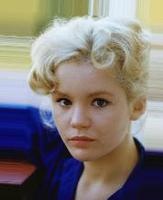

1/1 [==============================] - 0s 29ms/step



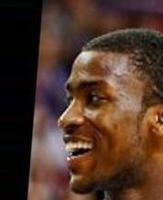

1/1 [==============================] - 0s 27ms/step



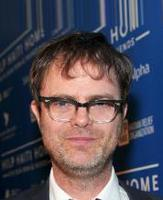

1/1 [==============================] - 0s 28ms/step



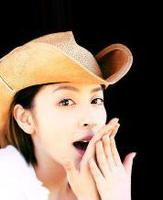

1/1 [==============================] - 0s 27ms/step



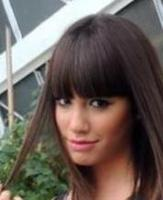

1/1 [==============================] - 0s 27ms/step



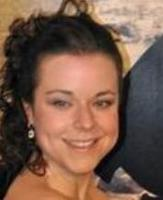

1/1 [==============================] - 0s 27ms/step



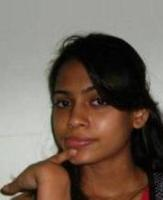

1/1 [==============================] - 0s 26ms/step



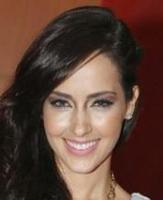

In [ ]:
#select random images of the test partition
df_to_test = df_par_attr[(df_par_attr['partition'] == 2)].sample(8)

for index, target in df_to_test.iterrows():
    result = gender_prediction(images_folder + index)
    
    #display result
    display_result(images_folder + index, result[0], target['Male'])

I hope you enjoyed this Notebook :) Please feel free to ask me question you may have or make improvements to the Notebook. Cheers!